In [110]:
import pandas as pd
%matplotlib inline

df = pd.read_csv('municipality_bus_utilization.csv',parse_dates=True)
df.head()

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [111]:
#pip install --user "numpy<1.24"

In [112]:
#from pmdarima import auto_arima

In [113]:
df.dtypes

timestamp          object
municipality_id     int64
usage               int64
total_capacity      int64
dtype: object

In [114]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dtypes

timestamp          datetime64[ns]
municipality_id             int64
usage                       int64
total_capacity              int64
dtype: object

In [115]:
# to have the max usage of every hour i just ignore minute and second and create a new col named timestamp_new
def insert_time(row):
    return row['timestamp'].replace( minute=0, second=0)

df['timestamp_new'] = df.apply(lambda r: insert_time(r), axis=1)

In [116]:
df.head()

,timestamp,municipality_id,usage,total_capacity,timestamp_new
0,2017-06-04 07:59:42,9,454,1332,2017-06-04 07:00:00
1,2017-06-04 07:59:42,8,556,2947,2017-06-04 07:00:00
2,2017-06-04 07:59:42,4,1090,3893,2017-06-04 07:00:00
3,2017-06-04 07:59:42,0,204,2813,2017-06-04 07:00:00
4,2017-06-04 07:59:42,7,718,2019,2017-06-04 07:00:00


In [117]:
# as mentioned in the task aggragate data to calculate just one usage for every hour (for every municipality)
df_new=pd.DataFrame(df.groupby(['timestamp_new','municipality_id'])[['usage','total_capacity']].max())

In [118]:
df_new=df_new.reset_index()
df_new.columns=['timestamp_new','municipality_id','usage','total_capacity']

In [119]:
df_new.head()

,timestamp_new,municipality_id,usage,total_capacity
0,2017-06-04 07:00:00,0,204,2813
1,2017-06-04 07:00:00,1,129,397
2,2017-06-04 07:00:00,2,273,697
3,2017-06-04 07:00:00,3,623,1930
4,2017-06-04 07:00:00,4,1090,3893


In [120]:
# for every municipality i create a new df to make predictions for each

df_names=["df0", "df1", "df2","df3","df4","df5","df6","df7","df8","df9"]

for i in range(10):
    vars()[df_names[i]]= pd.DataFrame(df_new[df_new['municipality_id']==i].set_index('timestamp_new'))

In [121]:
df0.head()

,municipality_id,usage,total_capacity
timestamp_new,,,
2017-06-04 07:00:00,0,204,2813
2017-06-04 08:00:00,0,332,2813
2017-06-04 09:00:00,0,485,2813
2017-06-04 10:00:00,0,583,2813
2017-06-04 11:00:00,0,614,2813


In [122]:
# train test split --- given in the info that last 2 week gonna be test period
df_names=["df0", "df1", "df2","df3","df4","df5","df6","df7","df8","df9"]
df_names_test=["df0_test", "df1_test", "df2_test","df3_test","df4_test","df5_test","df6_test","df7_test","df8_test","df9_test"]
df_names_train=["df0_train", "df1_train", "df2_train","df3_train","df4_train","df5_train","df6_train","df7_train","df8_train","df9_train"]

for i in range(10):
    vars()[df_names_test[i]]= pd.DataFrame(vars()[df_names[i]].loc['2017-08-06 00:00:00':])

for i in range(10):
    vars()[df_names_train[i]]= pd.DataFrame(vars()[df_names[i]].loc[:'2017-08-05 23:59:59'])

In [123]:
df0_train.shape, df0_test.shape, 

((541, 3), (133, 3))

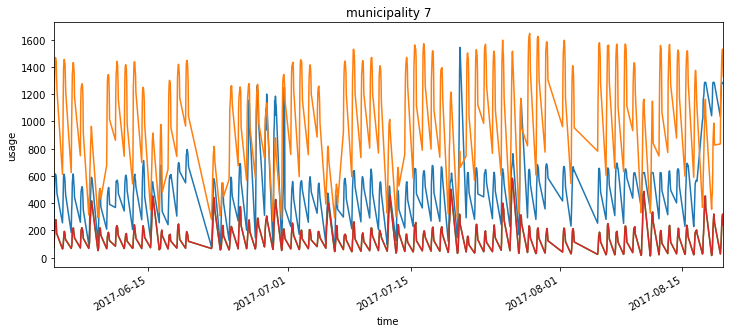

In [124]:
# check the trend and seasonality of some of municipalities . seems they have same seasonalty and no trend with different levels of usage

ax = df0['usage'].plot(figsize=(12,5),title="municipality 0")
ax = df3['usage'].plot(figsize=(12,5),title="municipality 3")
ax = df5['usage'].plot(figsize=(12,5),title="municipality 5")
ax = df5['usage'].plot(figsize=(12,5),title="municipality 7")
ax.autoscale(axis='x',tight=True)
ax.set(xlabel="time", ylabel="usage");


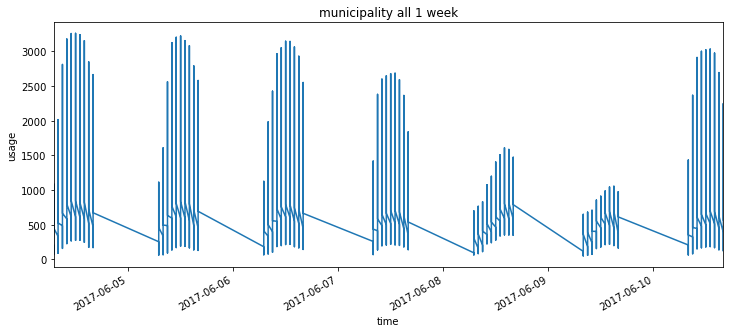

In [125]:
# moreover to determine the seasonality i took a closer look at data
# it seems there is a hourly seasonal data for 10 hours measured
df_new_=pd.DataFrame(df_new.set_index('timestamp_new'))
df_new__=df_new_.loc[:'2017-06-10 23:59:59']


ax = df_new__['usage'].plot(figsize=(12,5),title="municipality all 1 week")
ax.autoscale(axis='x',tight=True)
ax.set(xlabel="time", ylabel="usage");

# ## predictions for  municipalities: 3

In [200]:
#SARIMA(p,d,q)(P,D,Q)m
# Seasonal Autoregressive Integrated Moving Averages

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima                              # for determining ARIMA orders

In [228]:
# For SARIMA Orders we set seasonal=True and pass in an m value ( m is 10 because there is 10 hours from 7:00 to 16:00 measured)
# PREDICTION FOR municipalities: 3
auto_arima(df3["usage"],with_intercept=False,seasonal=True,m=10).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  674
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 10)   Log Likelihood               -4516.195
Date:                              Thu, 02 Mar 2023   AIC                           9040.391
Time:                                      20:05:30   BIC                           9058.438
Sample:                                           0   HQIC                          9047.379
                                              - 674                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L10       1.3489      0.043     31.290      0.000       1.264       1.433
ar.S.L20      -0.4968      0.029    -17.154      0.000      -0.554      -0.440
ma.S.L10      -0.8766      0.052    -16.783      0.000      -0.979      -0.774
sigma2      3.917e+04   1269.007     30.867      0.000    3.67e+04    4.17e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):               509.47
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [243]:
#Fit a SARIMAX(0, 1, 0)x(2, 0, [1], 10)	 Model
model = SARIMAX(df3_train['usage'],trend=None,order=(0, 1, 0),seasonal_order=(2, 0, [1], 10))
SARIMAXresult_df3 = model.fit()
SARIMAXresult_df3.summary()

C:\Users\ipek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ipek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                usage   No. Observations:                  541
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 10)   Log Likelihood               -3628.191
Date:                              Thu, 02 Mar 2023   AIC                           7264.382
Time:                                      20:15:17   BIC                           7281.549
Sample:                                           0   HQIC                          7271.096
                                              - 541                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L10       1.2703      0.044     28.666      0.000       1.183       1.357
ar.S.L20      -0.4628      0.034    -13.474      0.000      -0.530      -0.396
ma.S.L10      -0.8547      0.055    -15.644      0.000      -0.962      -0.748
sigma2      3.978e+04   1441.563     27.597      0.000     3.7e+04    4.26e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               417.58
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.58
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [247]:
# predicted values
start=len(df3_train)
end=len(df3_train)+len(df3_test)-1
predictions_df3 = SARIMAXresult_df3.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(0, 1, 0)x(2, 0, [1], 10) Predictions')


C:\Users\ipek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [248]:
pd.DataFrame(predictions_df3)

,"SARIMAX(0, 1, 0)x(2, 0, [1], 10) Predictions"
541,1176.671914
542,1188.405049
543,1347.322003
544,1447.061430
545,1490.653620
...,...
669,1312.211332
670,1310.920582
671,1309.694015
672,1307.326021


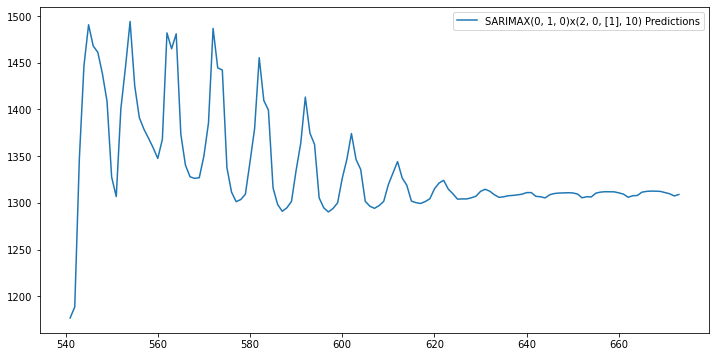

In [249]:
# Plot predictions 
ax = pd.DataFrame(predictions_df3).plot(legend=True,figsize=(12,6))


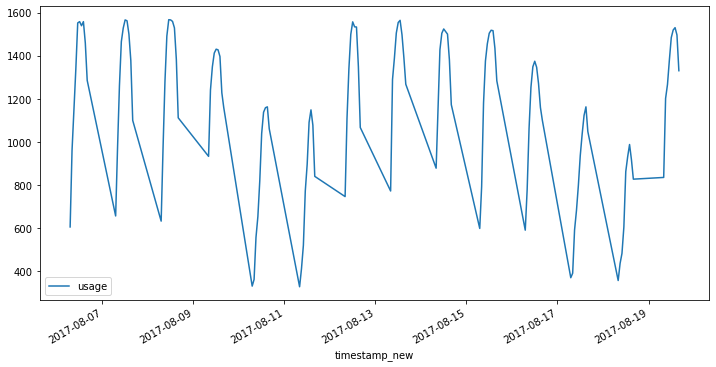

In [250]:
ax = df3_test['usage'].plot(legend=True,figsize=(12,6))

# ## predictions for municipalities: 9

In [252]:
auto_arima(df9["usage"],with_intercept=False,seasonal=True,m=10).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  674
Model:             SARIMAX(5, 1, 0)x(2, 0, [1, 2], 10)   Log Likelihood               -4137.293
Date:                                 Thu, 02 Mar 2023   AIC                           8294.585
Time:                                         20:27:08   BIC                           8339.703
Sample:                                              0   HQIC                          8312.057
                                                 - 674                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1397      0.043     -3.246      0.001      -0.224      -0.055
ar.L2         -0.1804      0.069     -2.610      0.009      -0.316      -0.045
ar.L3         -0.2057      0.073     -2.802      0.005      -0.350      -0.062
ar.L4         -0.1819      0.072     -2.519      0.012      -0.323      -0.040
ar.L5         -0.2004      0.056     -3.594      0.000      -0.310      -0.091
ar.S.L10       1.5157      0.094     16.164      0.000       1.332       1.700
ar.S.L20      -0.6867      0.092     -7.479      0.000      -0.867      -0.507
ma.S.L10      -1.1942      0.112    -10.621      0.000      -1.415      -0.974
ma.S.L20       0.3504      0.106      3.293      0.001       0.142       0.559
sigma2      1.272e+04    492.023     25.860      0.000    1.18e+04    1.37e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.26   Jarque-Bera (JB):              1045.21
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                            -1.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [254]:
#Fit a SARIMAX(5, 1, 0)x(2, 0, [1, 2], 10) Model
model9 = SARIMAX(df9_train['usage'],trend=None,order=(5, 1, 0),seasonal_order=(2, 0, [1, 2], 10))
SARIMAXresult_df9 = model9.fit()
SARIMAXresult_df9.summary()

C:\Users\ipek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ipek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ipek\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   usage   No. Observations:                  541
Model:             SARIMAX(5, 1, 0)x(2, 0, [1, 2], 10)   Log Likelihood               -3304.604
Date:                                 Thu, 02 Mar 2023   AIC                           6629.207
Time:                                         20:29:03   BIC                           6672.123
Sample:                                              0   HQIC                          6645.992
                                                 - 541                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0947      0.049     -1.918      0.055      -0.192       0.002
ar.L2         -0.1371      0.088     -1.560      0.119      -0.309       0.035
ar.L3         -0.1831      0.086     -2.137      0.033      -0.351      -0.015
ar.L4         -0.1942      0.086     -2.247      0.025      -0.363      -0.025
ar.L5         -0.2331      0.063     -3.728      0.000      -0.356      -0.111
ar.S.L10       1.2961      0.171      7.575      0.000       0.961       1.631
ar.S.L20      -0.5105      0.164     -3.119      0.002      -0.831      -0.190
ma.S.L10      -1.0114      0.184     -5.489      0.000      -1.373      -0.650
ma.S.L20       0.1904      0.172      1.109      0.267      -0.146       0.527
sigma2      1.204e+04    524.312     22.956      0.000     1.1e+04    1.31e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):              1022.08
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                            -1.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [255]:
# predicted values
start=len(df9_train)
end=len(df9_train)+len(df9_test)-1
predictions_df9 = SARIMAXresult_df9.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(5, 1, 0)x(2, 0, [1, 2], 10)	 Predictions')


C:\Users\ipek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


C:\Users\ipek\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ipek\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


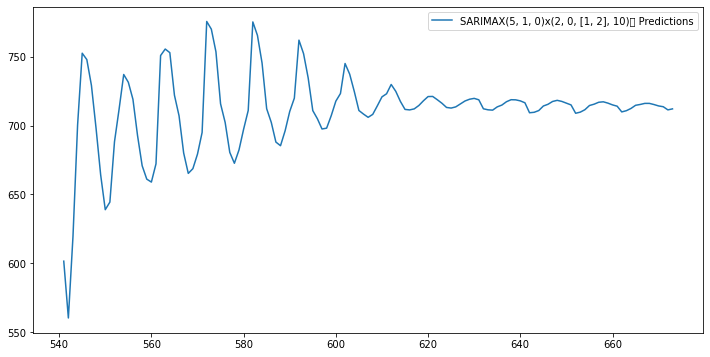

In [256]:
# Plot predictions 
ax = pd.DataFrame(predictions_df9).plot(legend=True,figsize=(12,6))


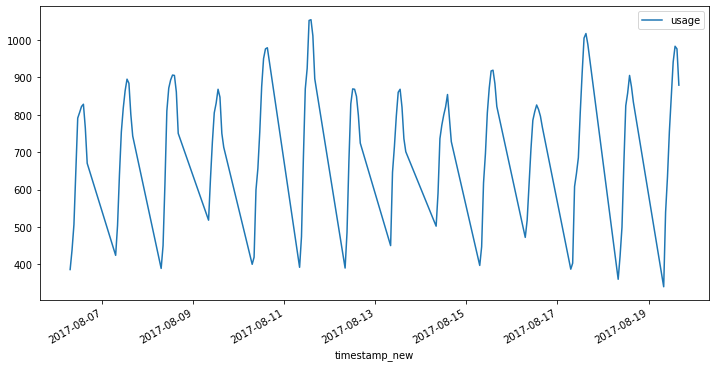

In [257]:
ax = df9_test['usage'].plot(legend=True,figsize=(12,6))